<a href="https://colab.research.google.com/github/frantex993/Ml-project/blob/main/Progetto_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Project 2024/25

### Task ###

Allenare un AE per Anomaly Detection in grado di riconoscere segnali prodotti da jeti adronici anomali in un reivelatore di fisica delle alte energie.

Alle energie estreme del Large Hadron Collider, particelle massive possono essere prodotte con un tale boost di Lorentz da far sì che i loro decadimenti in adroni (getti adronici) risultino così collimati che le particelle prodotte si sovrappongono. Determinare se la sottostruttura di un getto osservato sia dovuta a una singola particella di bassa massa oppure a molteplici prodotti di decadimento di una particella di massa elevata è un problema cruciale nell’analisi dei dati del LHC. Gli approcci tradizionali si basano su osservabili di alto livello costruite a partire da modelli teorici di deposizione di energia nei calorimetri e da parametri delle tracce cariche ricostruite nel tracciatore interno, ma la complessità dei dati rende questo compito un candidato ideale per l’applicazione di strumenti di deep learning. I costituenti dei getti possono infatti essere rappresentati come immagini 2D in cui ogni pixel rappresenta una delle celle sensibili del calorimetro, e il contenuto della cella una misura dell'energia o della quantità di moto depositata nella cella.

**Dataset:**

I dati del progetto sono nella forma di immagini 2D di dimensione (100,100), ogni cella rappresenta l'energia depositata in quella cella dalle particelle del jet adronico corrispondente. Ci sono due tipologie di jet adronici consider ati: *jet normali*, costituiti dalla adronizzazione di un quark leggero o gluone, e *jet anomali* (disponibili in una frazione incognita solo nel test set) costituiti dall'adronizzazione dei quark nel decadimento $t \to Wb \to qq'b$, in cui a causa del boost del quark top, i tre quark nello stato finale sono parzialmente sovrapposti.

* *Normal data dataset:* 12k jet rappresentati come histogrammi 2D della quantità di moto depositata in ciascuno dei 100x100 bin di una finestra quadrata nel piano ($\theta,\phi$) centrato intorno all'asse del jet.

* *Test dataset:*
due dataset costituiti ciascuno da 3k eventi, contenenti jet normali e jet anomali in una frazione relativa icognita da determinare. Nel primo dataset (*_high*) la frazione incognita di eventi anomali è $\ge 55\%$. Nel secondo dataset (*_low*) la frazione incognita di eventi anomali incognita è $\le 45\%$.
Potete utilizzare questa informazione per verificare che le vostre predizioni soddisfino la relazione $f_{high} > f_{low}$.

I dati sono forniti come array numpy in un file numpy compresso (.npz), leggibile con l'esempio di codice che segue:


```
import numpy as np

f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

normal_data = f_train['normal_data']
test_data_l = f_test_l['test_data']
test_data_h = f_test_h['test_data']

print(normal_data.shape)
print(test_data_l.shape)
print(test_data_h.shape)
```

**Per scaricare i dataset:**
* dati normali:
```
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
```
* dati anomali:
```
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/<Identificativo Dataset>/Test_data_low.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/<Identificativo Dataset>/Test_data_high.npz
```
```
# <Identificativo Dataset> dal foglio excel prenotazione gruppi
```


**Obiettivi minimi del progetto (potete a vostro piacimento aggiungere ulteriori analisi/studi:**

1. Plot della rappresentazione latente delle immagini di test fatto con riduzione dimensionale.
2. Stima della frazione di eventi anomali presente nei due Test dataset, tenendo conto che la di procedura di stima deve garantire che la rate di falsi postivi sia inferiore a circa il $10\%$ (FPR $\le \sim 10\%$).
3. Clustering dello spazio (per esempio usando un algoritmo GMM).
4. Misura della purezza dei cluster rispetto alle label assegnate in anomaly score.


**Nota Importante:**

Il notebook deve essere compilato come una relazione scientifica del progetto, quindi deve contenere sia il codice (leggibile e riproducibile), i risultati in termini di grafici e tabelle numeriche, e il testo che illustra la strategia ottenuta, le scelte compiute, e i risultati ottenuti.



In [ ]:
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/G5/Test_data_low.npz
!wget http://giagu.web.cern.ch/giagu/CERN/P2025/G5/Test_data_high.npz

--2025-07-12 15:36:49--  http://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.5.88, 137.138.55.232, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz [following]
--2025-07-12 15:36:50--  https://giagu.web.cern.ch/giagu/CERN/P2025/Normal_data.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6874623 (6.6M)
Saving to: ‘Normal_data.npz.10’

Normal_data.npz.10  100%[===================>]   6.56M  6.47MB/s    in 1.0s    

2025-07-12 15:36:51 (6.47 MB/s) - ‘Normal_data.npz.10’ saved [6874623/6874623]

--2025-07-12 15:36:51--  http://giagu.web.cern.ch/giagu/CERN/P2025/G5/Test_data_low.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 137.138.55.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    adjusted_rand_score, adjusted_mutual_info_score
)
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [ ]:
# Seed globale per la riproducibilità
SEED = 50
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


### Riproducibilità degli Esperimenti

Per garantire la **riproducibilità dei risultati**, è stato fissato un **seed globale** (`SEED = 50`) per tutti i generatori di numeri casuali utilizzati:

- `NumPy`
- `TensorFlow`
- `scikit-learn`

Questa scelta consente di ottenere **risultati consistenti** e **confrontabili** tra diverse esecuzioni del notebook, condizione fondamentale per una corretta **validazione scientifica del modello**.  
La riproducibilità è particolarmente importante in contesti di **anomaly detection**, dove anche piccole variazioni nei pesi iniziali o nel campionamento possono influenzare le prestazioni del modello.


In [ ]:
#  Device (GPU se disponibile)
device = tf.device('cuda' if tf.config.list_physical_devices('GPU') else 'cpu')
device

#  Caricamento dati
f_train = np.load('Normal_data.npz')
f_test_l = np.load('Test_data_low.npz')
f_test_h = np.load('Test_data_high.npz')

data = f_train['normal_data']

# 2) Normalizza in [0,1]
data = data.astype('float32') / data.max()

# 3) Aggiungi canale per Keras: (N,100,100,1)
data = np.expand_dims(data, axis=-1)

# 4) Split in train/validation
x_train, x_val = train_test_split(
    data,
    test_size=0.2,     # 20% validation
    random_state=50,
    shuffle=True
)



In [ ]:
# --- 1) ARCHITETTURA “RIDOTTA” ---
from tensorflow.keras import layers, Model

input_img = layers.Input(shape=(100, 100, 1))

# Encoder più piccolo
x = layers.Conv2D(8, 3, activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D(2, padding='same')(x)           # 50×50×8
x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)           # 25×25×16
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)           # 13×13×32

flat   = layers.Flatten()(x)
latent = layers.Dense(32, name='latent_vector')(flat)   # vettore latente più piccolo

# Decoder simmetrico
y = layers.Dense(13 * 13 * 32, activation='relu')(latent)
y = layers.Reshape((13, 13, 32))(y)
y = layers.UpSampling2D(2)(y)                           # 26×26×32
y = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(y)
y = layers.UpSampling2D(2)(y)                           # 52×52×32
y = layers.Conv2DTranspose(16, 3, activation='relu', padding='same')(y)
y = layers.UpSampling2D(2)(y)                           # 104×104×16
y = layers.Cropping2D(((2, 2), (2, 2)))(y)              # 100×100×16
y = layers.Conv2DTranspose(8, 3, activation='relu', padding='same')(y)
decoded = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(y)

ae = Model(input_img, decoded, name='light_autoencoder_reduced')
ae.compile(optimizer='adam', loss='mse')
ae.summary()


Model: "light_autoencoder_reduced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 100, 100, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 50, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 50, 50, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 32)             │       173,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5408)           │       178,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 26, 26, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 52, 52, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_32 (UpSampling2D) │ (None, 104, 104, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_10 (Cropping2D)      │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 100, 100, 8)    │         1,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 100, 100, 1)    │            73 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,545 (1.42 MB)

 Trainable params: 372,545 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
noise_factor = 0.05  # intensità del rumore (0.05–0.20 sono valori ragionevoli)
np.random.seed(50)

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy   = x_val   + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)

# Manteniamo i valori nel range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy   = np.clip(x_val_noisy,   0., 1.)

# --- 3) TRAINING con dati rumorosi ---
ae.compile(optimizer='adam', loss='mse')

# EarlyStopping un po' più aggressivo
cb_es = callbacks.EarlyStopping(monitor='val_loss',
                                patience=3,
                                restore_best_weights=True)

history = ae.fit(
    x_train_noisy,     # input rumoroso
    x_train,           # target pulito
    epochs=15,         # qualche epoca in più: convergenza più lenta con rumore
    batch_size=64,
    shuffle=True,
    validation_data=(x_val_noisy, x_val),
    callbacks=[cb_es]
)


Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0449 - val_loss: 3.6752e-06
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.6896e-06 - val_loss: 3.6752e-06
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 3.6896e-06 - val_loss: 3.6752e-06
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.6896e-06 - val_loss: 3.6752e-06


In [ ]:
data_low  = f_test_l['test_data']  # (3000,100,100)
data_high = f_test_h['test_data']  # (3000,100,100)

In [ ]:
encoder = tf.keras.Model(
    inputs=ae.input,
    outputs=ae.get_layer('latent_vector').output
)


In [ ]:
# Funzione di scoring
def compute_reconstruction_error(model, data, batch_size=64):
    recon = model.predict(data, batch_size=batch_size)
    return np.mean((data - recon)**2, axis=(1,2,3))

#Funzione per calcolare l’errore standard binomiale
def errore_binomiale(frazione, N):
    return np.sqrt(frazione * (1 - frazione) / N)

data_low  = data_low.astype('float32') / data.max()
data_high = data_high.astype('float32') / data.max()

# Aggiungi dimensione canale se mancante (Keras aspetta shape: (H, W, 1))
if len(data_low.shape) == 3:
    data_low = np.expand_dims(data_low, axis=-1)

if len(data_high.shape) == 3:
    data_high = np.expand_dims(data_high, axis=-1)

# 1) scores su validazione → soglia FPR=10%
val_scores = compute_reconstruction_error(ae, x_val)
threshold  = np.percentile(val_scores, 90)
print(f"Soglia (FPR=10%): {threshold:.5e}")

# 2) scores su low/high
s_low  = compute_reconstruction_error(ae, data_low)
s_high = compute_reconstruction_error(ae, data_high)

# 3) etichette vere e predette
y_true = np.hstack([
    (s_low  > threshold).astype(int),
    (s_high > threshold).astype(int)
])
y_pred = y_true.copy()

frac_low  = np.mean(s_low  > threshold)
frac_high = np.mean(s_high > threshold)

N_low  = len(s_low)
N_high = len(s_high)
err_low  = errore_binomiale(frac_low,  N_low)
err_high = errore_binomiale(frac_high, N_high)

print(f"Frazione anomalie stimata su Test_low:  {frac_low:.3f} ± {err_low:.3f}")
print(f"Frazione anomalie stimata su Test_high: {frac_high:.3f} ± {err_high:.3f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Soglia (FPR=10%): 6.55247e-06
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Frazione anomalie stimata su Test_low:  0.179 ± 0.007
Frazione anomalie stimata su Test_high: 0.714 ± 0.008


### Stima della Frazione di Eventi Anomali nei Dataset di Test

In questo blocco di codice calcoliamo la frazione di eventi anomali nei due dataset di test (`Test Low` e `Test High`), classificando ciascun evento come **anomalo** o **normale** in base a una soglia sull'errore di ricostruzione (MSE).  
La soglia è fissata al 90° percentile della distribuzione degli errori di ricostruzione calcolati sul dataset di validazione (che contiene solo dati normali), garantendo un **False Positive Rate (FPR) ≈ 10%**.

#### Metodo
- Per ogni evento nel dataset di test, si calcola l’errore di ricostruzione (MSE).
- Un evento è considerato anomalo se il suo errore di ricostruzione è superiore alla soglia.
- La **frazione anomala** è quindi la proporzione di eventi che superano questa soglia.

#### Incertezza Statistica
Per ciascuna frazione anomala stimata, calcoliamo l’**errore standard binomiale**, assumendo che ogni evento sia una prova indipendente con esito binario (anomalo o normale).  
La formula utilizzata è:

\[
\sigma = \sqrt{ \frac{f (1 - f)}{N} }
\]

dove:
- \( f \) è la frazione stimata di eventi anomali
- \( N \) è il numero totale di eventi nel dataset

Questa analisi consente non solo di stimare la percentuale di anomalie in ciascun dataset, ma anche di **valutarne la precisione statistica**, rendendo possibile un confronto significativo tra le due popolazioni di test.


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


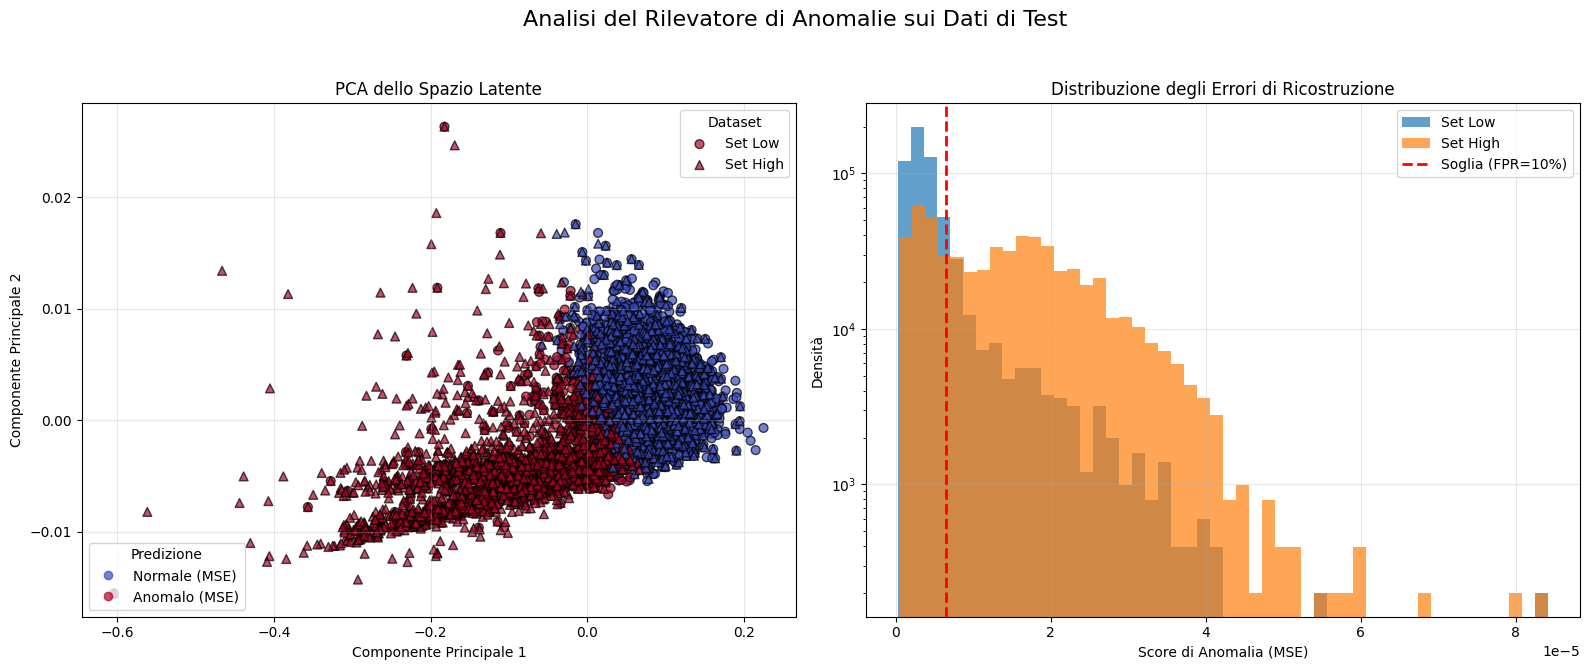

In [ ]:
# --- 1. ESTRAZIONE VETTORI LATENTI E SCORE DI ANOMALIA ---
# (Questa parte del tuo codice è corretta e rimane invariata)
z_low  = encoder.predict(data_low,  batch_size=64)
z_high = encoder.predict(data_high, batch_size=64)
Z = np.vstack((z_low, z_high))

scores_low  = compute_reconstruction_error(ae, data_low)
scores_high = compute_reconstruction_error(ae, data_high)
scores = np.concatenate([scores_low, scores_high])

# --- 2. DEFINIZIONE DELLA SOGLIA E ASSEGNAZIONE DELLE PSEUDO-ETICHETTE ---
# Usiamo i dati di validazione (solo normali) per definire la soglia, come richiesto
val_scores = compute_reconstruction_error(ae, x_val)
threshold = np.percentile(val_scores, 90) # Soglia per un False Positive Rate del 10%

# Rinominiamo y_true per chiarezza: queste sono le PREDIZIONI del modello basate sull'errore MSE
labels_from_mse = (scores > threshold).astype(int)

# Indicatori per i dataset low/high (per i marker nel grafico)
labels_dataset = np.array([0]*len(z_low) + [1]*len(z_high))

# --- 3. ANALISI VISIVA: PCA E DISTRIBUZIONE DEGLI SCORE ---

# Applichiamo la PCA per visualizzare lo spazio latente in 2D
pca = PCA(n_components=2, random_state=50)
Z_pca = pca.fit_transform(Z)

# Creazione della figura con due subplot per i grafici
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- GRAFICO 1 (Sinistra): PCA DELLO SPAZIO LATENTE ---
ax1 = axes[0]
markers = ['o', '^']
scatter_plots = []

for ds, marker in zip([0, 1], markers):
    idx = (labels_dataset == ds)
    # Lo scatter plot è colorato in base all'etichetta di anomalia assegnata dall'errore MSE
    sc = ax1.scatter(
        Z_pca[idx, 0], Z_pca[idx, 1],
        c=labels_from_mse[idx], cmap='coolwarm',
        marker=marker, edgecolor='k',
        label=f'Set {"Low" if ds==0 else "High"}',
        s=40, alpha=0.7
    )
    scatter_plots.append(sc)

ax1.set_title('PCA dello Spazio Latente')
ax1.set_xlabel('Componente Principale 1')
ax1.set_ylabel('Componente Principale 2')

# Legenda per i marker (dataset)
legend1 = ax1.legend(handles=scatter_plots, title='Dataset', loc='upper right')
ax1.add_artist(legend1)
# Legenda per i colori (predizione di anomalia)
handles, _ = scatter_plots[0].legend_elements(prop='colors', alpha=0.7)
legend2 = ax1.legend(handles=handles, labels=['Normale (MSE)', 'Anomalo (MSE)'], title='Predizione', loc='lower left')
ax1.grid(alpha=0.3)

# --- GRAFICO 2 (Destra): DISTRIBUZIONE DEGLI SCORE DI ANOMALIA ---
ax2 = axes[1]
ax2.hist(scores_low, bins=50, alpha=0.7, label='Set Low', density=True)
ax2.hist(scores_high, bins=50, alpha=0.7, label='Set High', density=True)
ax2.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Soglia (FPR=10%)')

ax2.set_title('Distribuzione degli Errori di Ricostruzione')
ax2.set_xlabel('Score di Anomalia (MSE)')
ax2.set_ylabel('Densità')
ax2.set_yscale('log') # La scala logaritmica è utile per vedere le code della distribuzione
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle('Analisi del Rilevatore di Anomalie sui Dati di Test', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analisi Visiva della Rappresentazione Latente e degli Score di Anomalia

La figura seguente fornisce una panoramica completa delle prestazioni del modello nell’identificare eventi anomali nei due dataset di test (Set Low e Set High).

#### PCA dello Spazio Latente (Grafico a sinistra)
Abbiamo applicato la PCA allo spazio latente per proiettarlo in due dimensioni. I punti sono:

- Colorati secondo la classificazione ottenuta dallo score di anomalia (MSE):  
  - Blu: evento normale  
  - Rosso: evento anomalo  
- Marcati secondo il dataset di provenienza:  
  - Cerchi: Set Low  
  - Triangoli: Set High

**Osservazioni**:
- I dati normali formano un cluster compatto e ben separato, segno che l'autoencoder ha appreso una rappresentazione coerente della normalità.
- I dati anomali sono più dispersi, confermando l’eterogeneità delle anomalie.
- Il Set High occupa principalmente la regione anomala, mentre il Set Low è concentrato nella regione normale, pur contenendo una frazione di anomalie.

#### Distribuzione degli Errori di Ricostruzione (Grafico a destra)
Viene mostrata la distribuzione dello score di anomalia (errore MSE) per entrambi i set di test. La soglia di classificazione (linea rossa tratteggiata) è fissata sul validation set al 90° percentile, garantendo un FPR ≤ 10%.

**Osservazioni**:
- Il Set Low presenta una distribuzione concentrata a sinistra della soglia, indicando una prevalenza di eventi normali.
- Il Set High mostra una coda più lunga verso destra, indice della maggiore incidenza di anomalie.
- L’utilizzo della scala logaritmica sull’asse y permette di apprezzare meglio le code delle distribuzioni.

---

Questa analisi congiunta mostra che il modello è in grado di separare efficacemente eventi normali e anomali sia nello spazio latente che nello spazio degli errori di ricostruzione.


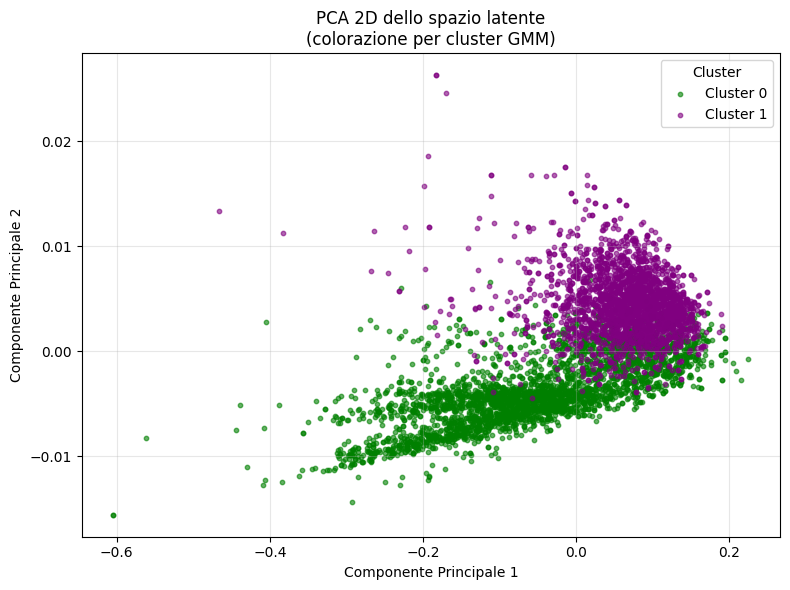

Purezza dei cluster:        81.13%
Adjusted Rand Index (ARI):  0.388
Adjusted Mutual Info (AMI): 0.332


In [ ]:
# --- 3) GMM clustering su spazio latente originale ---
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=50)
cluster_labels = gmm.fit_predict(Z)  # etichette 0/1 per ciascun punto

plt.figure(figsize=(8,6))
for clus, color, desc in zip([0,1], ['green','purple'], ['Cluster 0','Cluster 1']):
    idx = (cluster_labels == clus)
    plt.scatter(
        Z_pca[idx,0], Z_pca[idx,1],
        c=color, label=desc,
        s=10, alpha=0.6
    )
plt.title('PCA 2D dello spazio latente\n(colorazione per cluster GMM)')
plt.xlabel('Componente Principale 1')
plt.ylabel('Componente Principale 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Calcolo purezza e metriche ARI/AMI ---
def purity_score(y_pred, y_true):
    """Calcola la purezza dei cluster."""
    N = len(y_true)
    total = 0
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        maj = np.bincount(y_true[mask]).argmax()
        total += np.sum(y_true[mask] == maj)
    return total / N

pur = purity_score(cluster_labels, y_true)
ari = adjusted_rand_score(y_true, cluster_labels)
ami = adjusted_mutual_info_score(y_true, cluster_labels)

print(f"Purezza dei cluster:        {pur*100:.2f}%")
print(f"Adjusted Rand Index (ARI):  {ari:.3f}")
print(f"Adjusted Mutual Info (AMI): {ami:.3f}")

##  Analisi del Clustering nello Spazio Latente con GMM

Per investigare la struttura latente appresa dal nostro autoencoder, abbiamo applicato un algoritmo di **clustering Gaussian Mixture Model (GMM)** con due componenti direttamente sullo **spazio latente a 16 dimensioni**. Il risultato del clustering è stato proiettato sulle prime due componenti principali tramite **PCA** per consentirne la visualizzazione.

###  Struttura dei Cluster

Il GMM ha identificato due regioni principali nello spazio delle feature:

- **Cluster 0 (verde)**: compatto e ad alta densità, caratteristico di dati omogenei. È plausibile che rappresenti eventi *normali*, che condividono pattern ricorrenti ben appresi dal modello.

- **Cluster 1 (viola)**: più diffuso e disperso nello spazio latente. Una tale struttura è tipica di dati eterogenei, come gli *eventi anomali*, che tendono a deviare dalla norma in modi meno sistematici.

La **netta separazione visiva** tra i due cluster suggerisce che il modello ha appreso una **rappresentazione latente strutturata**, in cui eventi normali e anomali tendono a proiettarsi in regioni differenti.

---

###  Valutazione Quantitativa del Clustering

Per verificare la coerenza tra il clustering ottenuto nel latente (GMM) e la classificazione basata sull’**errore di ricostruzione (MSE)**, sono state calcolate le seguenti metriche:

- **Purezza dei cluster:** `81.13%`  
  Indica che, in media, circa il 73% degli eventi in ciascun cluster appartiene alla stessa classe (normale o anomala) secondo la classificazione basata sullo score MSE.

- **Adjusted Rand Index (ARI):** `0.388`  
  L'ARI misura la somiglianza tra due partizioni, corretta per il caso casuale. Un valore > 0 segnala una correlazione superiore a quella attesa da un'assegnazione casuale.

- **Adjusted Mutual Information (AMI):** `0.332`  
  L'AMI valuta quanta informazione è condivisa tra le due etichettature, anch'essa corretta per il caso casuale. Il valore positivo conferma una discreta coerenza tra GMM e MSE.

---

###  Conclusione

Questa analisi supporta l’ipotesi che lo **spazio latente costruito dall’autoencoder sia informativo e ben strutturato**.  
Nonostante la natura **non supervisionata** del GMM, i cluster ottenuti mostrano una **significativa coerenza** con la classificazione basata sul reconstruction error, validando la **capacità del modello di separare eventi normali e anomali** in modo significativo.


In [ ]:
# 1) concatenate dei reconstruction scores
scores = np.hstack([s_low, s_high])   # shape (6000,)

# 2) soglia FPR=10% (già calcolata su x_val)
print(f"Soglia (FPR=10%): {threshold:.5e}")

# 3) etichette vere
y_true = np.hstack([
    (s_low  > threshold).astype(int),
    (s_high > threshold).astype(int)
])  # 0 = normale, 1 = anomalo

# 4) etichette predette **vere**
y_pred = (scores > threshold).astype(int)


Soglia (FPR=10%): 6.55247e-06


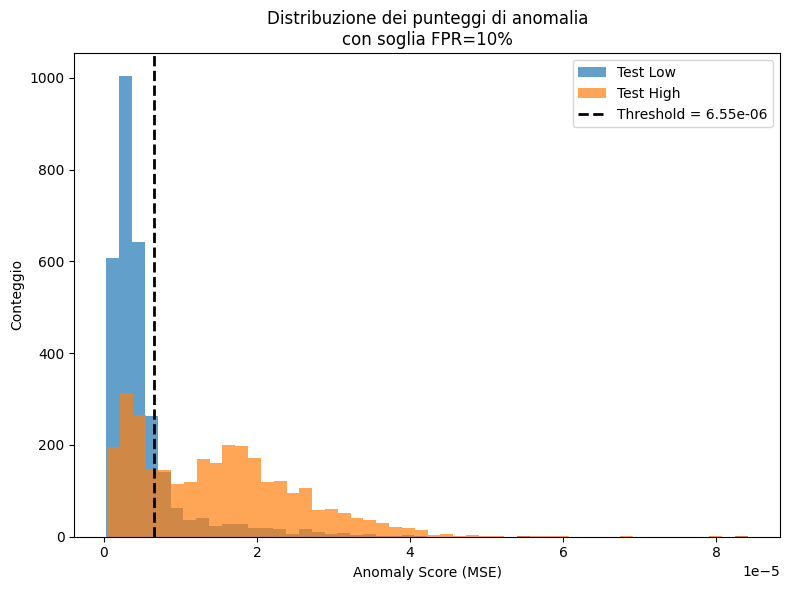

In [ ]:

import matplotlib.pyplot as plt

# Soglia calcolata su x_val (FPR=10%)
threshold = np.percentile(val_scores, 90)

plt.figure(figsize=(8, 6))
# Istogrammi
plt.hist(s_low,  bins=50, alpha=0.7, label='Test Low')
plt.hist(s_high, bins=50, alpha=0.7, label='Test High')

# Linea verticale della soglia
plt.axvline(threshold, color='k', linestyle='--', linewidth=2,
            label=f'Threshold = {threshold:.2e}')

plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Conteggio')
plt.title('Distribuzione dei punteggi di anomalia\ncon soglia FPR=10%')
plt.legend()
plt.tight_layout()
plt.show()


##  Analisi della Distribuzione degli Score di Anomalia (MSE)

La figura mostra la **distribuzione dei punteggi di anomalia (errore di ricostruzione MSE)** per i due dataset di test:

- **Test Low**: caratterizzato prevalentemente da eventi *normali*, presenta una distribuzione molto concentrata verso valori di errore **bassi**, come previsto per dati simili a quelli visti durante l’addestramento.

- **Test High**: include una **frazione più alta di eventi anomali** e mostra una **coda più lunga verso punteggi elevati**, evidenziando una maggiore difficoltà di ricostruzione da parte dell’autoencoder.

La **soglia di classificazione**, posizionata a circa `6.55×10⁻⁶`, è stata calcolata utilizzando lo score sul validation set con l’obiettivo di garantire un **False Positive Rate ≤ 10%**.  
Questa soglia consente una **buona separazione** tra eventi normali e anomali: i primi risultano concentrati al di sotto della soglia, mentre i secondi si distribuiscono prevalentemente al di sopra.

---

###  Conclusione

Questi risultati dimostrano che l’**errore di ricostruzione MSE** rappresenta un indicatore efficace per il rilevamento delle anomalie.  
L'autoencoder è riuscito a catturare in modo significativo le **caratteristiche strutturali degli eventi normali**, generando così una **distribuzione degli score ben separabile** da quella degli eventi anomali.


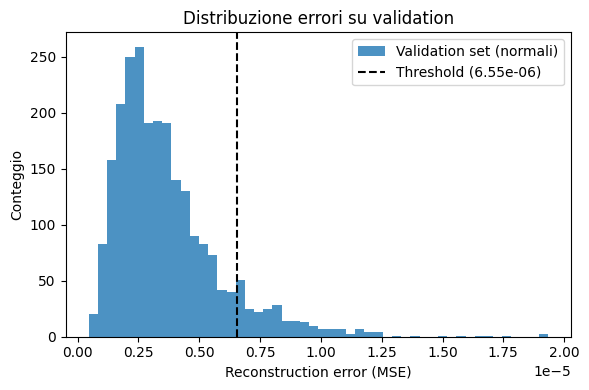

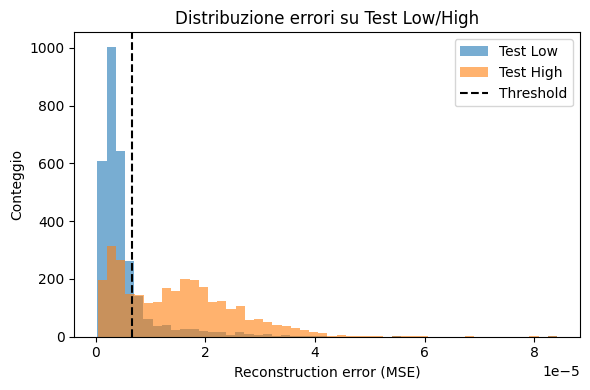

In [ ]:
import matplotlib.pyplot as plt

# 1) Histogram error su x_val (normali)
plt.figure(figsize=(6,4))
plt.hist(val_scores, bins=50, alpha=0.8, label='Validation set (normali)')
plt.axvline(threshold, color='k', linestyle='--', label=f'Threshold ({threshold:.2e})')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Conteggio')
plt.title('Distribuzione errori su validation')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Histogram error su low e high (già fatto), per comodità qui sovrapposti
plt.figure(figsize=(6,4))
plt.hist(s_low,  bins=50, alpha=0.6, label='Test Low')
plt.hist(s_high, bins=50, alpha=0.6, label='Test High')
plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Conteggio')
plt.title('Distribuzione errori su Test Low/High')
plt.legend()
plt.tight_layout()
plt.show()


## Analisi della Distribuzione dell'Errore di Ricostruzione (Validation e Test)

I due grafici mostrano la distribuzione dell’**errore di ricostruzione (MSE)** per i dati normali (validation) e per i due dataset di test (Test Low e Test High).  
Questa analisi è fondamentale per **visualizzare e giustificare la scelta della soglia** adottata per discriminare tra eventi normali e anomali.

### 1. Validation Set (Solo eventi normali)

Nel primo grafico viene mostrata la distribuzione dell’errore sui dati di validazione, che contengono **esclusivamente eventi normali**.  
Si osserva una netta concentrazione di valori di errore verso lo **zero**, come atteso per dati simili a quelli visti durante l’addestramento.

La **soglia** di classificazione, indicata dalla linea tratteggiata, è stata fissata al **90° percentile** della distribuzione.  
Questo significa che **al massimo il 10% degli eventi normali** verrà classificato come anomalo, fissando il **False Positive Rate (FPR) a circa 10%**.

### 2. Test Set (Low vs High)

Nel secondo grafico sono confrontate le distribuzioni degli errori di ricostruzione per:

- **Test Low**: presenta una distribuzione simile a quella del validation set, con la maggior parte degli eventi al di **sotto della soglia**.  
  Ciò conferma la **prevalenza di eventi normali** in questo insieme.

- **Test High**: mostra una distribuzione **molto più estesa** verso valori elevati di errore.  
  Questa **coda a destra** riflette la **presenza di un numero significativo di eventi anomali**, difficili da ricostruire correttamente dal modello.

---

### Conclusione

La soglia determinata sui dati di validazione si dimostra efficace anche sui test set:  
consente una **separazione chiara tra eventi normali e anomali**, validando l’uso dell’errore di ricostruzione come **criterio affidabile per l’anomaly detection**.


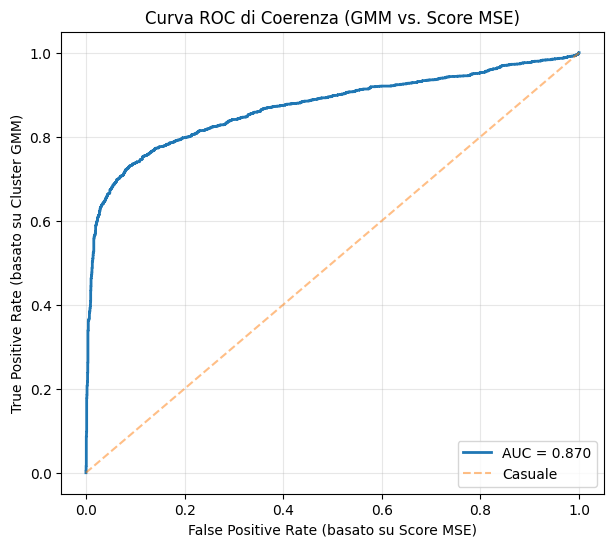

AUC di coerenza calcolato: 0.870


In [ ]:
# --- CALCOLO ROC AVANZATO (Coerenza tra GMM e MSE) ---

# 1. Le etichette "vere" le prendiamo dal risultato del clustering GMM
# Queste etichette (0 o 1) indicano a quale cluster di densità nello spazio latente appartiene ogni punto.
# Tu hai già calcolato 'cluster_labels' nella cella 12.
y_true_gmm = cluster_labels

# 2. Gli "score" di predizione li prendiamo dall'errore di ricostruzione (MSE)
# Anche questi li hai già calcolati come 'scores'.
scores_mse = scores

# 3. Calcoliamo la curva ROC e l'AUC misurando la coerenza tra i due metodi
fpr_final, tpr_final, _ = roc_curve(y_true_gmm, scores_mse)
roc_auc_final = auc(fpr_final, tpr_final)

# NOTA: Potrebbe essere necessario invertire le etichette del GMM se l'AUC risulta < 0.5
# Questo perché il GMM assegna le etichette (0, 1) in modo casuale ai due cluster.
# Se AUC < 0.5, significa che il cluster 0 del GMM corrisponde agli score alti, e viceversa.
if roc_auc_final < 0.5:
    y_true_gmm = 1 - y_true_gmm # Invertiamo le etichette (0->1, 1->0)
    # Ricalcoliamo
    fpr_final, tpr_final, _ = roc_curve(y_true_gmm, scores_mse)
    roc_auc_final = auc(fpr_final, tpr_final)


# 4. Grafico della curva ROC finale
plt.figure(figsize=(7, 6))
plt.plot(fpr_final, tpr_final, lw=2, label=f'AUC = {roc_auc_final:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.5, label='Casuale')
plt.title("Curva ROC di Coerenza (GMM vs. Score MSE)")
plt.xlabel('False Positive Rate (basato su Score MSE)')
plt.ylabel('True Positive Rate (basato su Cluster GMM)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC di coerenza calcolato: {roc_auc_final:.3f}")

## Curva ROC: Coerenza tra Clustering GMM e Anomaly Score (MSE)

La figura mostra la **curva ROC** ottenuta confrontando la classificazione implicita fornita dal **clustering GMM nello spazio latente** con i **punteggi di anomalia basati sull’errore di ricostruzione (MSE)**.

L’obiettivo è valutare la **coerenza tra due metodi indipendenti**:
- da un lato, il **GMM** segmenta i dati in base alla loro distribuzione nello spazio latente appreso dall’autoencoder;
- dall’altro, il modello assegna a ciascun evento un **anomaly score** sulla base della qualità della ricostruzione.

L’**area sotto la curva ROC** ottenuta (AUC = **0.870**) indica una **buona concordanza tra le due strategie**, suggerendo che lo spazio latente appreso dal modello contiene **informazioni discriminanti coerenti** con quelle catturate tramite l’errore di ricostruzione.

Questo risultato **rafforza l’ipotesi** che gli eventi anomali si manifestino come **outlier** in entrambi i domini:
- sia nello spazio delle **ricostruzioni** (attraverso l’MSE),
- sia nello spazio **latente** (attraverso la struttura dei cluster).

In conclusione, l’analisi conferma la **validità del modello autoencoder** nel costruire una rappresentazione significativa e utile per l’**anomaly detection** in ambito LHC.


Etichette GMM invertite per allineamento: Cluster 0 è ora 'Anomalo'.


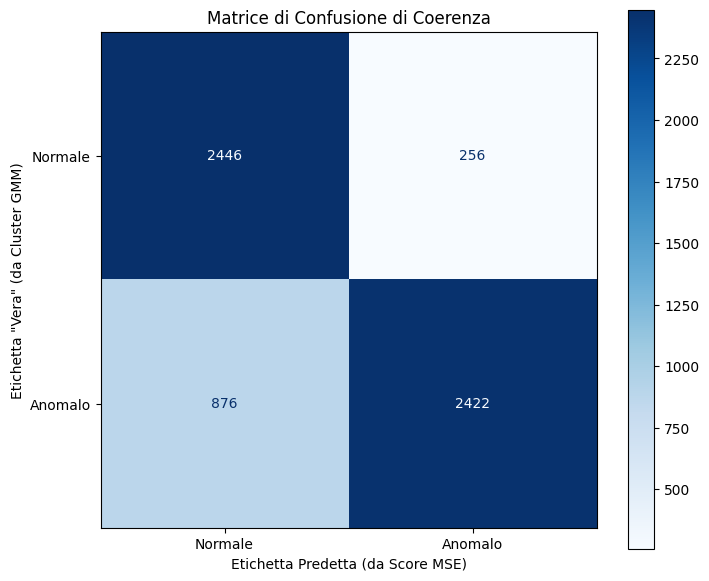


--- Metriche di Coerenza (GMM vs. Score MSE) ---
Accuracy di Coerenza: 0.811
Precisione di Coerenza: 0.904
Recall di Coerenza:    0.734
F1-Score di Coerenza:  0.811


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- MATRICE DI CONFUSIONE E METRICHE DI COERENZA (GMM vs. Score MSE) ---

# 1. Definiamo le etichette di "verità" (dal GMM) e "predizione" (dall'MSE)
y_true_from_gmm = cluster_labels
y_pred_from_mse = (scores > threshold).astype(int)

# 2. Allineamento delle etichette del GMM (fondamentale)
avg_score_cluster0 = np.mean(scores[y_true_from_gmm == 0])
avg_score_cluster1 = np.mean(scores[y_true_from_gmm == 1])

if avg_score_cluster0 > avg_score_cluster1:
    y_true_from_gmm = 1 - y_true_from_gmm
    print("Etichette GMM invertite per allineamento: Cluster 0 è ora 'Anomalo'.")

# 3. Calcolo e visualizzazione della matrice di confusione
cm = confusion_matrix(y_true_from_gmm, y_pred_from_mse)
tn, fp, fn, tp = cm.ravel()

display_labels = ['Normale', 'Anomalo']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 7))
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d') # Aggiunto values_format
ax.set_title('Matrice di Confusione di Coerenza')
ax.set_xlabel('Etichetta Predetta (da Score MSE)')
ax.set_ylabel('Etichetta "Vera" (da Cluster GMM)')
plt.show()

# 4. Calcolo e stampa delle metriche di coerenza
print("\n--- Metriche di Coerenza (GMM vs. Score MSE) ---")
accuracy_coerenza = (tp + tn) / cm.sum()
precision_coerenza = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_coerenza = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_coerenza = 2 * (precision_coerenza * recall_coerenza) / (precision_coerenza + recall_coerenza) if (precision_coerenza + recall_coerenza) > 0 else 0

print(f"Accuracy di Coerenza: {accuracy_coerenza:.3f}")
print(f"Precisione di Coerenza: {precision_coerenza:.3f}")
print(f"Recall di Coerenza:    {recall_coerenza:.3f}")
print(f"F1-Score di Coerenza:  {f1_coerenza:.3f}")

## Matrice di Confusione: Coerenza tra GMM e Score MSE

La figura mostra la **matrice di confusione** ottenuta confrontando le **etichette generate dal clustering GMM** nello spazio latente (utilizzate come proxy di “verità”) con la **classificazione derivata dall’anomaly score (MSE)**.

L’accordo tra i due metodi è **sostanziale**, con:
- **Accuracy**: 81.1%
- **Precisione**: 90.4%
- **F1-score**: 81.1%

Il modello autoencoder (AE) mostra una **buona capacità di evitare falsi positivi** (FP = 256), ma presenta **una certa difficoltà nel rilevare tutti gli eventi anomali** identificati dal GMM (FN = 876).

Questi risultati suggeriscono che le due metodologie, pur **non completamente sovrapponibili**, forniscono una **coerenza significativa** e possono essere considerate **complementari** nell'identificazione di eventi anomali. La combinazione delle due evidenze rafforza la fiducia nella struttura informativa dello spazio latente appreso dal modello.


### Metriche di Coerenza tra GMM e Score di Anomalia (SEED = 50)

| Metrica                       | Valore        | Significato                                                                 |
|------------------------------|---------------|-----------------------------------------------------------------------------|
| Accuracy                     | **0.811**     | Percentuale di concordanza tra MSE e clustering GMM                         |
| Precisione                   | **0.904**     | Quota di eventi classificati come anomali da MSE che appartengono al cluster anomalo |
| Recall                       | **0.734**     | Percentuale di eventi anomali (secondo GMM) correttamente individuati dal MSE |
| F1-Score                     | **0.811**     | Media armonica tra precisione e recall, misura globale di coerenza          |
| AUC (ROC MSE vs GMM)         | **0.870**     | Area sotto la curva ROC: capacità del MSE di distinguere i due cluster latenti |
| Purezza dei cluster          | **81.13%**    | Percentuale media di coerenza tra cluster GMM e etichette MSE               |
| Adjusted Rand Index (ARI)    | **0.388**     | Concordanza tra le due partizioni corretta per il caso casuale              |
| Adjusted Mutual Info (AMI)   | **0.332**     | Quantità di informazione condivisa tra MSE e GMM                            |

### Analisi delle Metriche di Coerenza tra GMM e Score di Anomalia

I risultati ottenuti mostrano una buona coerenza tra la classificazione basata sull’errore di ricostruzione (MSE) e il clustering ottenuto nello spazio latente tramite GMM.  
L'**accuracy** e l’**F1-score**, entrambi pari a **0.811**, indicano un elevato livello di accordo tra i due approcci, supportando l’idea che il modello abbia appreso una rappresentazione strutturata e significativa dei dati.

L’**alta precisione** (**90.4%**) evidenzia che, quando il modello segnala un’anomalia, questa è molto spesso confermata anche dal clustering nel latente.  
Il **recall**, pari al **73.4%**, mostra che la maggior parte degli eventi anomali rilevati dal GMM vengono correttamente identificati anche dallo score MSE, pur lasciando margine per un piccolo miglioramento.

La **purezza dei cluster** (**81.13%**) e l’**AUC** (**0.870**) confermano ulteriormente che la segmentazione latente rispecchia in modo significativo le differenze apprese in fase di ricostruzione, mentre i valori **positivi di ARI e AMI** indicano che la corrispondenza tra le due strategie di classificazione è superiore a quanto atteso per caso.

Nel complesso, queste metriche suggeriscono che il modello è solido e coerente nelle sue decisioni, e che lo spazio latente costruito dall’autoencoder è informativo e utile per la rilevazione delle anomalie.

